In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2021-01-28 00:41:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.192.80, 74.125.137.128, 142.250.101.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.192.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  65.8MB/s    in 3.5s    

2021-01-28 00:41:38 (65.8 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [2]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [31]:
embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 160000
test_portion = .1

corpus = []

In [32]:
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader: 
    list_item = []
    list_item.append(row[5])
    label = row[0]
    if label == '0':
      list_item.append(0)
    else:
      list_item.append(1)
    num_sentences = num_sentences + 1
    corpus.append(list_item)  

In [33]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [36]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [37]:
print(vocab_size)
print(word_index['i'])

138639
1


In [38]:
# Glove
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

--2021-01-28 01:31:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  68.9MB/s    in 4.8s    

2021-01-28 01:32:01 (68.9 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [43]:
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [44]:
print(len(embeddings_matrix))

138640


In [53]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           13864000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 14,055,617
Trainable params: 191,617
Non-trainable params: 13,864,000
_________________________________________________________________


In [54]:
num_epochs = 50

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)
print("Training Complete")

Epoch 1/50
4500/4500 - 114s - loss: 0.5299 - accuracy: 0.7305 - val_loss: 0.4963 - val_accuracy: 0.7549
Epoch 2/50
4500/4500 - 108s - loss: 0.4785 - accuracy: 0.7686 - val_loss: 0.4774 - val_accuracy: 0.7721
Epoch 3/50
4500/4500 - 108s - loss: 0.4520 - accuracy: 0.7845 - val_loss: 0.4742 - val_accuracy: 0.7720
Epoch 4/50
4500/4500 - 107s - loss: 0.4295 - accuracy: 0.7973 - val_loss: 0.4675 - val_accuracy: 0.7744
Epoch 5/50
4500/4500 - 108s - loss: 0.4057 - accuracy: 0.8112 - val_loss: 0.4693 - val_accuracy: 0.7822
Epoch 6/50
4500/4500 - 107s - loss: 0.3809 - accuracy: 0.8243 - val_loss: 0.4837 - val_accuracy: 0.7696
Epoch 7/50
4500/4500 - 107s - loss: 0.3528 - accuracy: 0.8404 - val_loss: 0.4945 - val_accuracy: 0.7741
Epoch 8/50
4500/4500 - 107s - loss: 0.3212 - accuracy: 0.8565 - val_loss: 0.5438 - val_accuracy: 0.7682
Epoch 9/50
4500/4500 - 106s - loss: 0.2892 - accuracy: 0.8719 - val_loss: 0.5969 - val_accuracy: 0.7644
Epoch 10/50
4500/4500 - 106s - loss: 0.2564 - accuracy: 0.8885 -

<Figure size 432x288 with 0 Axes>

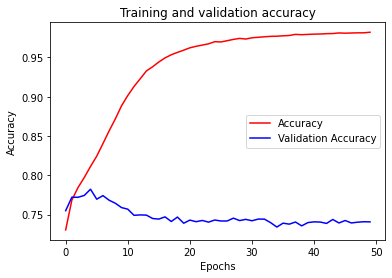

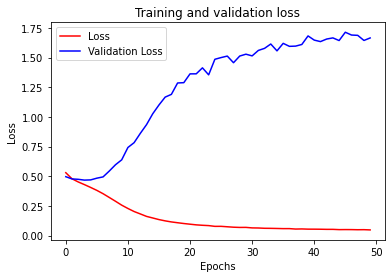

<Figure size 432x288 with 0 Axes>

In [55]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
